#Imports and settings

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
# nicer plots, but only available in recent matplotlib
try:
    plt.style.use('ggplot')
except:
    pass
import hrf_estimation as he
print('You are running hrf_estimation version %s' % he.__version__)
import pandas as pd
import nibabel as nib
from socket import gethostname
pd.set_option('display.max_columns', 500)
from timeit import default_timer


Populating the interactive namespace from numpy and matplotlib
You are running hrf_estimation version 1.1


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days


# defining functions for stuff

In [2]:
def load_database(subject):
    host_name = gethostname()
    if host_name == 'circe':
            db = '/home/nick/Desktop/CO_dataset/db.csv'
            data_path = '/home/nick/Desktop/CO_dataset/'
    if host_name == 'Ichi':
            db = '/mnt/em9k.csv'
    else:
        raise Exception('Hostname {} does not have a db.'.format(gethostname()))

    data_db = pd.read_csv(db,index_col = False)
    if host_name == 'circe':
        data_db['frame_file_path'] = '/home/nick/Desktop/CO_dataset/'
    if host_name == 'Ichi':
        data_db.frame_file_path = data_db.frame_file_path.apply(lambda x: x.replace('/Data/7T.cmrr/','/musc.repo/mri/7T.cmrr/'))
        data_db.frame_file_path += '/'
    lotushill_data = data_db[data_db['expID']=='lotusHill.7T.em9K.1.5iso'][['subject', 'runType', 'TR', 'matrix_x',
                                                                            'matrix_y', 'n_slices', 'nvols','frame_file_path',
                                                                            'frame_file', 'working_vol','brain_mask']]
    return lotushill_data[(lotushill_data['subject']==subject)]

def load_data(df_row):
    return nib.load(df_row['working_vol'])

def load_mask(df_row):
    return nib.load(df_row['brain_mask'])


def plot_voxel(cur_vols):
    which_voxel = (50,50,18)
    one_vol = load_data(cur_vols.iloc[0])
    time_course = one_vol.get_data()[which_voxel[0], which_voxel[1], which_voxel[2], :]
    plt.figure(figsize=(18, 6))
    plt.plot(time_course, lw=2)
    plt.xlabel('Timecourse (in seconds)')
    
    
def image_id(string_list):
    try:
        digits = map(lambda x: int(x.replace('.png', '')), string_list)
    except:
        1/0
    big = np.argmax(digits)
    return digits[big], string_list[big]


def load_frame_file(df_row):    
    cond_file = df_row['frame_file_path'] + df_row['frame_file']
    with open(cond_file, 'r') as content_file:
        cond_list = content_file.read()
    cond_list = cond_list.strip().split('\n')

    return cond_list

##returns 
def load_conditions(df_row):
  
    TR = df_row['TR']
    cond_list = load_frame_file(df_row)
    chunksize = len(cond_list) / df_row['nvols']  ##each chunk should span 1 TR
    condition_map = dict() ## a map from image_ids to a condition number
    condition_number = 0   ##this will determine the design matrix column for each image
    condition_sequence = [] ##the sequence in which images were shown
    condition_onsets = []  ##the times (in seconds) when images were shown
    for TR_counter, chunk in enumerate(range(0,len(cond_list), chunksize)):
        one_tr = cond_list[chunk:chunk+chunksize]
        stim_digit, stim_string = image_id(one_tr) ##<<grab the image id
        if stim_digit > 0:
            if stim_string not in condition_map.keys():
                condition_map[stim_string] = condition_number
                condition_number += 1
            condition_sequence.append(condition_map[stim_string])
            condition_onsets.append(TR_counter*TR)
    return [condition_map, condition_sequence, condition_onsets]


def do_detrend(voxin):
    window_length = 91 ##<<play with this. 
    poly_order = 3 ##<<mess with this too
    filt =  he.savitzky_golay.savgol_filter(voxin, window_length, poly_order, axis=0)
    return (voxin - filt)  / voxin.std(axis=0)

import itertools
def flatten(l):
    return list(itertools.chain(*l))



# loading database and building condition lists

In [3]:
cur_vols = load_database('CO')
cur_vols

cond_info = load_conditions(cur_vols.iloc[0])
cur_vols['volume_data'] = cur_vols.apply(lambda row: load_data(row), axis=1)
cur_vols['condition_info'] = cur_vols.apply(lambda row: load_conditions(row), axis=1)
# plot_voxel(cur_vols)

cur_vols.head()

,subject,runType,TR,matrix_x,matrix_y,n_slices,nvols,frame_file_path,frame_file,working_vol,brain_mask,volume_data,condition_info
5,CO,trn,2,108,108,39,210,/musc.repo/mri/7T.cmrr/Presentation/Oct2011/,trn001.txt,/mnt/initial_em9k_pipe/CO_nofnirt/lotusHill.7T...,/mnt/initial_em9k_pipe/CO_nofnirt//lotusHill.7...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"[{u'002650.png': 32, u'000294.png': 16, u'0031..."
6,CO,trn,2,108,108,39,210,/musc.repo/mri/7T.cmrr/Presentation/Oct2011/,trn002.txt,/mnt/initial_em9k_pipe/CO_nofnirt/lotusHill.7T...,/mnt/initial_em9k_pipe/CO_nofnirt//lotusHill.7...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"[{u'000162.png': 2, u'002477.png': 27, u'00324..."
7,CO,trn,2,108,108,39,210,/musc.repo/mri/7T.cmrr/Presentation/Oct2011/,trn003.txt,/mnt/initial_em9k_pipe/CO_nofnirt/lotusHill.7T...,/mnt/initial_em9k_pipe/CO_nofnirt//lotusHill.7...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"[{u'000804.png': 12, u'002773.png': 10, u'0025..."
8,CO,val,2,108,108,39,210,/musc.repo/mri/7T.cmrr/Presentation/Oct2011/,val001.txt,/mnt/initial_em9k_pipe/CO_nofnirt/lotusHill.7T...,/mnt/initial_em9k_pipe/CO_nofnirt//lotusHill.7...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"[{u'003463.png': 5, u'002723.png': 2, u'003656..."
9,CO,imgVal,2,108,108,39,232,/musc.repo/mri/7T.cmrr/Presentation/Oct2011/,imgVal.txt,/mnt/initial_em9k_pipe/CO_nofnirt/lotusHill.7T...,/mnt/initial_em9k_pipe/CO_nofnirt//lotusHill.7...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"[{u'004247.png': 4, u'004246.png': 0, u'004245..."


# concatenating run data to form one run

In [5]:

onsets_all_sessions = []
voxels_all_sessions = []
conditions_all_sessions = []
n_basis = 20


def add_dict(di,pad):
    for key in di:
        di[key] += pad
    return di
def add_list(li,pad):
    return [i + pad for i in li]


def mult_runs():
    onset_pad = 0
    dict_pad  = 0
    for sess in xrange(len(cur_vols.index)):

        print '{}/{} sessions done ; {}%'.format(sess,len(cur_vols.index),round((float(sess+1) / len(cur_vols.index)) * 100,1))
        voxels = cur_vols.iloc[sess].volume_data.get_data()
        n_voxels = np.prod(voxels.shape[0:3])
        n_scans = cur_vols.iloc[sess].nvols
        voxels = voxels.reshape((n_voxels,n_scans))

        # add dict_pad to dict inside cur_vols
        cur_vols['condition_info'].iloc[sess][0] = add_dict(cur_vols['condition_info'].iloc[sess][0],dict_pad)
        # add dict_pad to conditions
        conditions = add_list(cur_vols['condition_info'].iloc[sess][1],dict_pad) 
        # add onset_pad for onsets
        onsets = np.array(cur_vols['condition_info'].iloc[sess][2]) + onset_pad

        # append lists
        onsets_all_sessions.append(onsets)
        conditions_all_sessions.append(conditions)

        # detrending
        n_voxels = voxels.shape[-1]
        voxels = np.subtract(voxels, he.savitzky_golay.savgol_filter(voxels, 91, 3, axis=0))
        voxels /= voxels.std(axis=0)
        
        voxels_all_sessions.append(voxels)
        
        dict_pad += len(np.unique(conditions))
        onset_pad += cur_vols.iloc[sess].nvols * 2

mult_runs()


0/11 sessions done ; 9.1%
1/11 sessions done ; 18.2%
2/11 sessions done ; 27.3%
3/11 sessions done ; 36.4%
4/11 sessions done ; 45.5%
5/11 sessions done ; 54.5%
6/11 sessions done ; 63.6%
7/11 sessions done ; 72.7%
8/11 sessions done ; 81.8%
9/11 sessions done ; 90.9%
10/11 sessions done ; 100.0%


In [6]:
# checking voxel length
check_vox_1 = sum(cur_vols.nvols)
check_vox_2 = sum([vox.shape[1] for vox in voxels_all_sessions])
check_vox_3 = map(max,onsets_all_sessions)
if check_vox_1 != check_vox_2:
    print 'voxels arent right'
print check_vox_1
print check_vox_2

# need to check onsets systematically
##
#  (nvols * tr) - last onset + next first onset without pad should equal first onset with pad
##
del check_vox_1
del check_vox_2
del check_vox_3

2354
2354


In [7]:
check = []
for i in xrange(len(cur_vols.index)):
    for key in cur_vols['condition_info'].iloc[i][0]:
        check.append((cur_vols['condition_info'].iloc[i][0][key],key))

indexes = [i[0] for i in check]
for i in indexes:
    if indexes.count(i) > 1:
        print i

pngs = [i[1] for i in check]
for i in pngs:
    if pngs.count(i) > 1:
        print i
        
del indexes
del pngs

In [8]:
# Flattening conditions for multi-run

onsets = list(flatten(onsets_all_sessions))
conditions = list(flatten(conditions_all_sessions))
zz = np.hstack(voxels_all_sessions)
print 'voxel shape: {}'.format(zz.shape)

print 'n_conditions: {}'.format( len(np.unique(conditions)))


voxel shape: (454896, 2354)
n_conditions: 240


In [ ]:
# need memory (this saved 6GB on 11 runs; an issue with ipython caching)
del conditions_all_sessions
del onsets_all_sessions
del voxels_all_sessions
print zz.shape


# Only running a handful of voxels to show error

In [12]:
random_voxels = np.random.randint(0,high=zz.shape[0],size=1000)
drifts = np.ones((zz.T.shape[0], 1))


base='fir'
hrfs, betas = he.glm(conditions, onsets, 2., zz[random_voxels,:].T, drifts = drifts,mode='r1glm', basis=base, verbose=1,n_jobs=1)



.. creating design matrix ..
.. done creating design matrix ..
.. computing initialization ..
.. done initialization ..
.. completed 500 out of 1000 ..
.. completed 1000 out of 1000 ..


ValueError: shapes (1000,10) and (20,) not aligned: 10 (dim 1) != 20 (dim 0)

In [230]:
r = rsquares[:]

print mask.shape[0]
r_to_image = np.zeros((mask.shape[0],1))
print r_to_image.shape[0]
print len(r)
for i in xrange(mask.shape[0]):
    if mask[i] != 0:
        if len(r) > 0:
             r_to_image[i] = r.pop(0)
r_to_image =r_to_image.reshape((108,108,39))
        
img = nib.Nifti1Image(r_to_image ,np.eye(4))
nib.save(img,'/home/nick/Desktop/3hrf_test.nii')



454896
454896
121874


<matplotlib.colorbar.Colorbar instance at 0x7f667b1b3cb0>

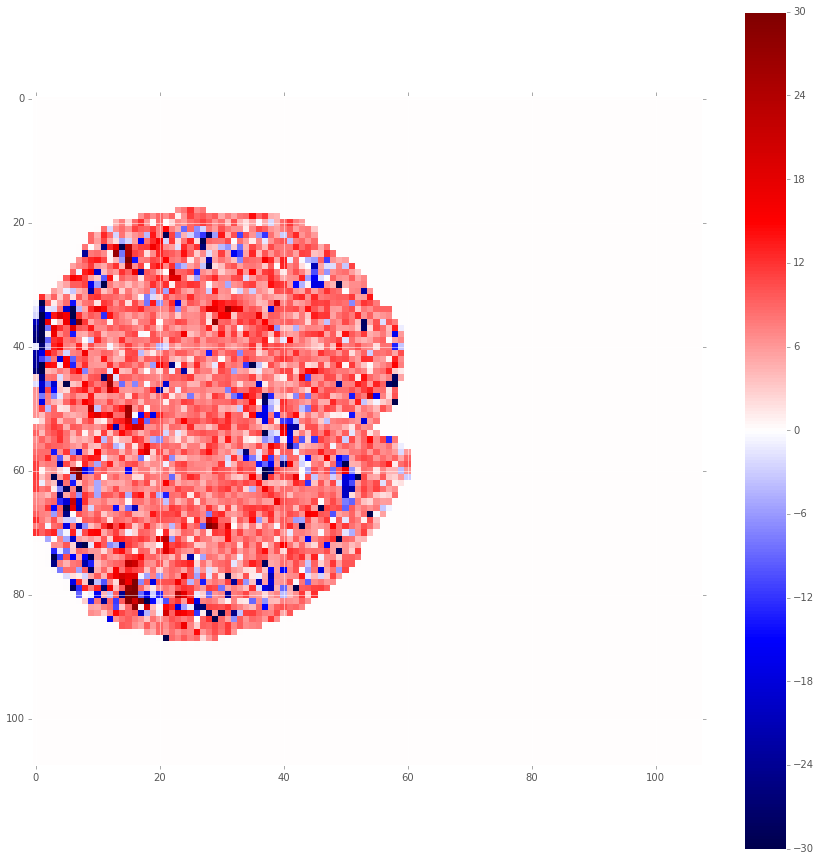

In [267]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,15

p = imshow(r_to_image[:,:,20],interpolation='none',vmin=-30,vmax=30)
p.set_cmap('seismic')
colorbar()


(108, 108)
15-20 : 2260
20-25 : 622
25-35 : 396
35+ : 55


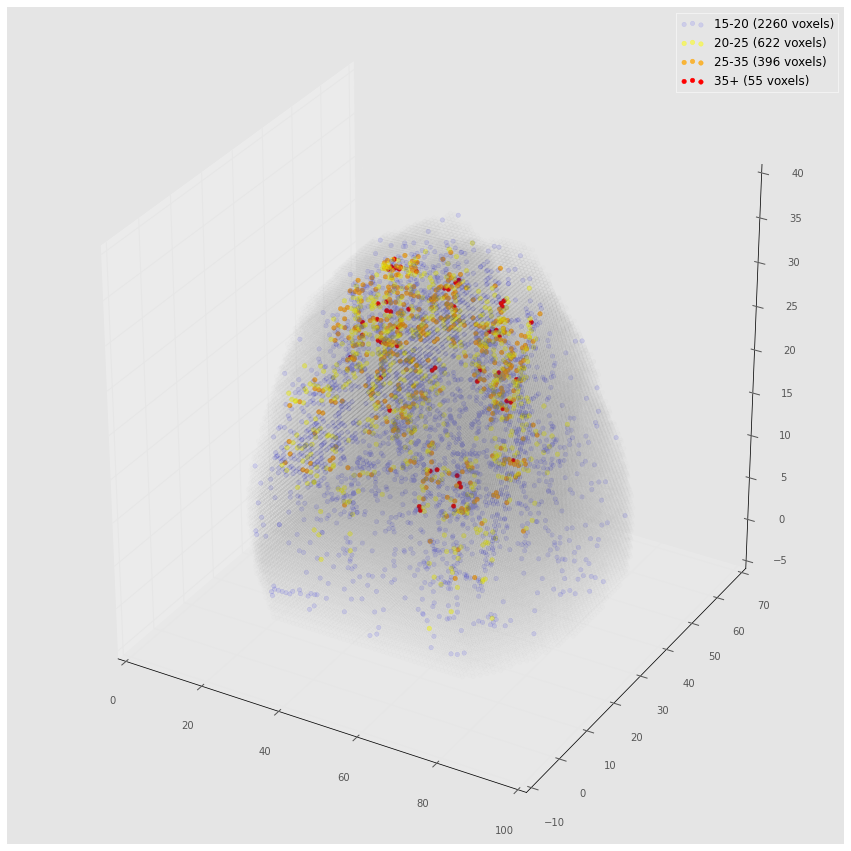

In [368]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

data = r_to_image[:,:,20]
print data.shape

# data[data == 0] = numpy.nan

x2535,y2535,z2535 = [],[],[]
x35,y35,z35 = [],[],[]
x2015,y2015,z2015 = [],[],[]
xa,ya,za = [],[],[]
x2520,y2520,z2520 = [],[],[]

mask = load_mask(cur_vols.iloc[which_run]).get_data()

for x in xrange(r_to_image.shape[0]):
    for y in xrange(r_to_image.shape[1]):
        for z in xrange(r_to_image.shape[2]):
            if mask[x,y,z] != 0:
                xa.append(x)
                ya.append(y)
                za.append(z)
            if 20 > r_to_image[x,y,z] > 15:
                x2015.append(x)
                y2015.append(y)
                z2015.append(z)
            if 25 > r_to_image[x,y,z] > 20:
                x2520.append(x)
                y2520.append(y)
                z2520.append(z)
            if 35 > r_to_image[x,y,z] > 25:
                x2535.append(x)
                y2535.append(y)
                z2535.append(z)
            if  r_to_image[x,y,z] > 35:
                x35.append(x)
                y35.append(y)
                z35.append(z)

xx = np.array(xx)
yy = np.array(yy)
zz = np.array(zz)

print '15-20 : {}'.format(len(x2015))
print '20-25 : {}'.format(len(x2520))
print '25-35 : {}'.format(len(x2535))
print '35+ : {}'.format(len(x35))


# create the figure
fig = plt.figure()

# show the reference image
# ax1.imshow(data, cmap='seismic', interpolation='nearest', origin='lower', extent=[0,1,0,1])

# show the 3D rotated projection
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(xa,ya,za,alpha=.015,color='grey')

ax2.scatter(x2015,y2015,z2015,color='blue',alpha=.1,label='15-20 ({} voxels)'.format(len(x2015)))
ax2.scatter(x2520,y2520,z2520,color='yellow',alpha=.5,label='20-25 ({} voxels)'.format(len(x2520)))
ax2.scatter(x2535,y2535,z2535,color='orange',alpha=.75,label='25-35 ({} voxels)'.format(len(x2535)))
ax2.scatter(x35,y35,z35,color='red',alpha=1,label='35+ ({} voxels)'.format(len(x35)))

ax2.legend()

# ax2.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=plt.cm.seismic( r_to_image[:,:,21]), shade=False)

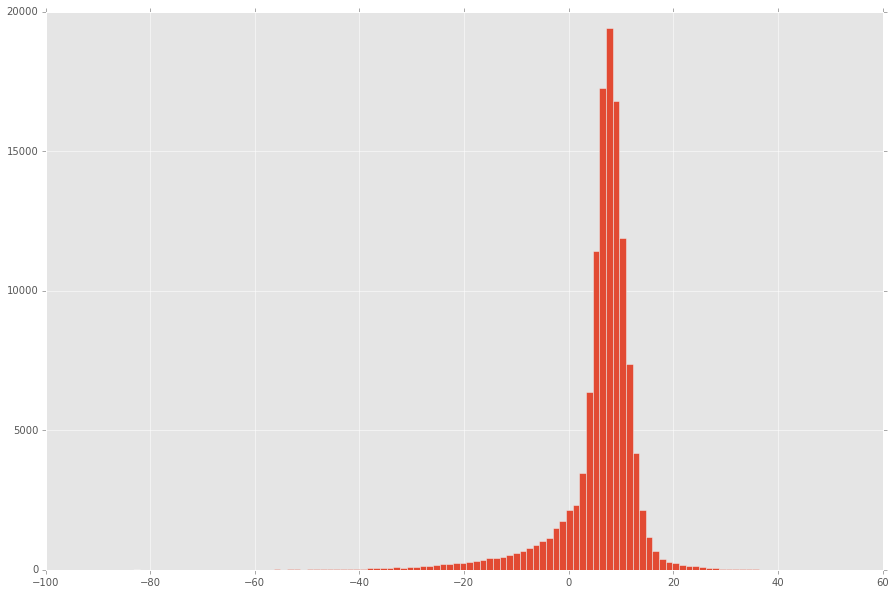

In [396]:
hist_data = rsquares
# hist_data[np.isnan(hist_data)] = 0
rcParams['figure.figsize'] = 15,10
x = hist(hist_data,bins=100,label='r-squared')